In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt

utilspath=os.path.join("..","..","util")
sys.path = [utilspath]+sys.path
import myLandlabTools as tools
%matplotlib inline

In [3]:
# make this True to load original data, if False, use summary xlsx to plot
loadDataFromSource = True

##  Overview

### Units

The units stated in the flow data file are cumecs (m$^3$/s) but the number of samples per day varies (from zero to four), so there is no indication of the total flow. The only information available in the flow data file is therefore the rate of flow as measured at a (small) number of discrete moments in time.  The analysis presented here provides two approaches: plot the values as present in the data file and (2) sum together the values for each day. The value of both these approaches are questionable, because there is no indication of the time duration of the flow.

There are no units given in the rainfall file, so presumably the units are mm per sample time period.  The total rainfall for the day is therefore simply the sum of all measurement samples.  This value seems reasonably trustworthy.

### Summary data

It takes quite a while to load the data, so after loading and processing, the summary data are written to Excel files: one file for the sampled data and one file for the summed-per-day data.  The subsequent analysis and plotting can then be done with the summary files.

## Read the flow discharge data

Read the flow discharge.  The code creates two files: one with the sample data and the second with maximum of the sample data during the day. So however many samples there are, the maximum value is always taken.

The date-time is reconstructed from the first two columns in the data file.  The first column is the date in the format `yyyymmdd` and the second column is the time in the format `hhmmss`.  A proper date-time is reconstructed from these two columns and used in the rest of the processing.

In [4]:
if loadDataFromSource:
    fnFlow = 'Flow Data.xlsx'
    for sumFlowPerDay in [True,False]:
        dfFlow = pd.read_excel(fnFlow,header=3,index_col=None)

        # move multi-index to columns
        dfFlow = dfFlow.reset_index()
        # make a string of the time of day, six chars long: hhmmss
        dfFlow['stime'] = dfFlow['level_1'].apply(lambda x: '{:06d}'.format(x))
        # append day and time into a long string
        dfFlow['sdate'] = dfFlow['level_0'].astype(str) + dfFlow['stime'].astype(str)
        # parse the string to extract and then form a datetime date http://strftime.org/
        dfFlow['dtDate'] = dfFlow['sdate'].apply(lambda x: pd.to_datetime(x, 
                                        format='%Y%m%d%H%M%S'))#, errors='ignore'))

        if sumFlowPerDay:
            # get rid of time, keep date only
            dfFlow['Date'] = dfFlow['dtDate'].dt.date
        else:
            # keep time
            dfFlow['Date'] = dfFlow['dtDate']

        # drop all columns not required
        dfFlow = dfFlow.drop(['stime','DATE','sdate','dtDate','level_0',
                              'level_1','level_2','Point', 'Qual', 'Inst', 
                              'Qual.1','Unnamed: 6','Unnamed: 7', 'RAINFALL'],axis=1)

        # set the date as the new index
        dfFlow.set_index('Date',inplace=True)
        if sumFlowPerDay:
            # max of multiple values for same date
            dfFlow = dfFlow.groupby(dfFlow.index).max()
            
        # drop all rows with NaN flow
        dfFlow = dfFlow.dropna(axis=0)
        # move date to columns
        dfFlow = dfFlow.reset_index()
        if sumFlowPerDay:
            excelfilename = 'FlowSummed'
        else:
            excelfilename = 'FlowSamples'

        writer = pd.ExcelWriter('{}.xlsx'.format(excelfilename))
        dfFlow.to_excel(writer,excelfilename)
        writer.save()


## Load the rainfall data

The rainfall data is given at 5 minute sample interval.  This is too dense for practical work, so we accumulate over the span of one day and over the span of one hour (resampled to sum during the one-hour intervals).

In [5]:
if loadDataFromSource:
    files = ['1994.xlsx','1995.xlsx','1996.xlsx','1997.xlsx','1998.xlsx',
    '1999.xlsx','2000.xlsx','2001.xlsx','2002.xlsx','2003.xlsx',
    '2004.xlsx','2005.xlsx','2006.xlsx','2007.xlsx','2008.xlsx',
    '2009.xlsx','2010.xlsx','2011.xlsx','2012.a.xlsx','2012.b.xlsx',
    '2013.a.xlsx','2013.b.xlsx','2014.a.xlsx','2014.b.xlsx','2015.a.xlsx',
    '2015.b.xlsx','2016.a.xlsx','2016.b.xlsx']

    path = '../Loots/unisa-sorted-20171106'

    for sumRainPerDay in [False]:
        dfRain = pd.DataFrame()
        for file in files:
            print(file, end=", ")
            dfT = pd.read_excel(os.path.join(path,file),header=None,index_col=None,
                                usecols=[0,1,2,3,4,5],
                                names=['Site','Lat','Lon','dDate','Rain','Temp'])
            if sumRainPerDay:
                # get rid of time, keep date only
                dfT['Date'] = dfT['dDate'].dt.date
            else:
                # keep time
                dfT['Date'] = dfT['dDate']
            # drop the unused columns
            dfT = dfT.drop(['Site','Lat','Lon','Temp','dDate'],axis=1)
            # set the date as the new index
            dfT.set_index('Date',inplace=True)
            if sumRainPerDay:
                # sum multiple values for same date
                dfT = dfT.groupby(dfT.index).sum()
            else:
                # resample to one-hour intervals and sum over the interval
                # https://chrisalbon.com/python/data_wrangling/pandas_group_data_by_time/
                # https://pandas.pydata.org/pandas-docs/stable/timeseries.html
                dfT = dfT.resample('H').sum()
            # drop all rows with NaN rainfall
            dfT = dfT.dropna(axis=0)
            # move date to columns
            dfT = dfT.reset_index()
            dfRain = dfRain.append(dfT)
        if sumRainPerDay:
            excelfilename = 'RainSummed'
        else:
            excelfilename = 'RainSamples'

        writer = pd.ExcelWriter('{}.xlsx'.format(excelfilename))
        dfRain.to_excel(writer,excelfilename)
        writer.save()
        print(' ')



1994.xlsx, 1995.xlsx, 1996.xlsx, 1997.xlsx, 1998.xlsx, 1999.xlsx, 2000.xlsx, 2001.xlsx, 2002.xlsx, 2003.xlsx, 2004.xlsx, 2005.xlsx, 2006.xlsx, 2007.xlsx, 2008.xlsx, 2009.xlsx, 2010.xlsx, 2011.xlsx, 2012.a.xlsx, 2012.b.xlsx, 2013.a.xlsx, 2013.b.xlsx, 2014.a.xlsx, 2014.b.xlsx, 2015.a.xlsx, 2015.b.xlsx, 2016.a.xlsx, 2016.b.xlsx,  


## Plot the data

The code thus far loaded the data and saved these to files.  Now use these files to plot the data either a sample values, or daily sums.  

The approach taken in these plots is somewhat naive in the sense that tens of thousands of data points (along the date/time line) are compressed in a plot of no more than about one thousand pixels.  This means that the original data cannot be accurately represented, because more than one sample will be (attempted to be) displayed in one pixel on the screen.  A more realistic approach would be to rescale the data with as many points on the time line as there are pixels in the width of the plot.  The resampling should be done by sum for the rainfall and by max for the flow.

In [9]:

def plotData(sumFlowPerDay,sumRainPerDay,saveFilename):
    if sumFlowPerDay:
        flowFilename = 'FlowSummed.xlsx'
    else:
        flowFilename = 'FlowSamples.xlsx'
        
    if sumRainPerDay:
        rainfilename = 'RainSummed.xlsx'
    else:
        rainfilename = 'RainSamples.xlsx'

    dfFlow = pd.read_excel(flowFilename,header=0,index_col=None)
    dfRain = pd.read_excel(rainfilename,header=0,index_col=None)

    # now start the plot
    fig, ax1 = plt.subplots(figsize=(10,5))
    flowColour = 'b' # 'k'
    rainColour = 'g' # 'k'
    ax1.plot(dfFlow['Date'], dfFlow['FINAL FLOW'], flowColour)
    ax1.set_xlabel('Date')
    if sumFlowPerDay:
        ax1.set_ylabel('Max m$^3$/s during day', color=flowColour)
    else:
        ax1.set_ylabel('m$^3$/s per sample', color=flowColour)
    ax1.tick_params('y', colors=flowColour)
    # scale to prevent overlap with other graph
    fmin,fmax = ax1.get_ylim()
    ax1.set_ylim(fmin,2*fmax)

    ax2 = ax1.twinx()
    ax2.plot(dfRain['Date'], dfRain['Rain'], rainColour)
    if sumRainPerDay:
        ax2.set_ylabel('Rain fall mm per day', color=rainColour)
    else:
        ax2.set_ylabel('Rain fall mm per hour', color=rainColour)
    ax2.tick_params('y', colors=rainColour)
    # scale to prevent overlap with other graph
    rfmin,rfmax = ax2.get_ylim()
    ax2.set_ylim(rfmin,2*rfmax)
    #invert the y axis
    ax2.invert_yaxis()
#     plt.suptitle('Measured flows and rainfall in cathcment area', fontsize=16)

    fig.tight_layout()
    fig.savefig(saveFilename,dpi=300)
    plt.show()


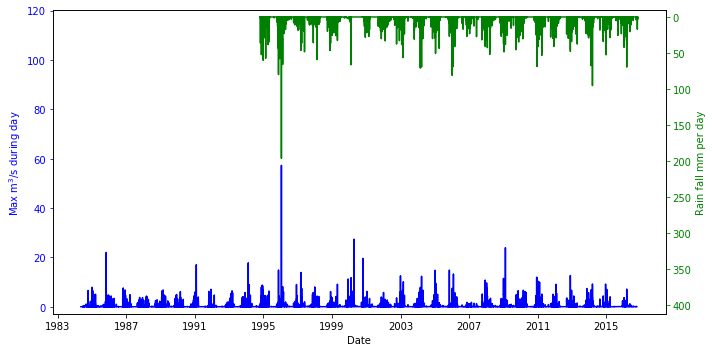

In [10]:
plotData(sumFlowPerDay=True,sumRainPerDay=True,saveFilename='SumFlowAndRainPerDay.png')

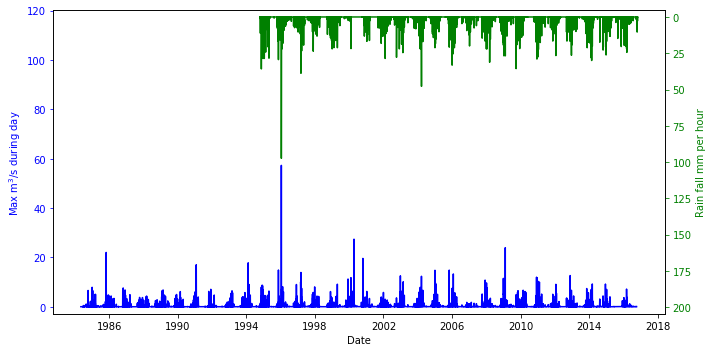

In [11]:
plotData(sumFlowPerDay=True,sumRainPerDay=False,saveFilename='SumFlowPerDay.png')

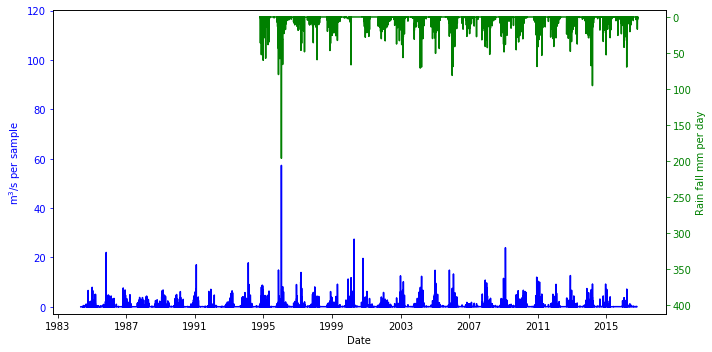

In [12]:
plotData(sumFlowPerDay=False,sumRainPerDay=True,saveFilename='SumRainPerDay.png')

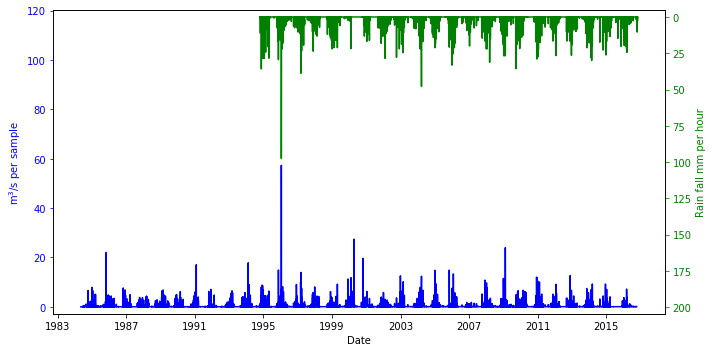

In [13]:
plotData(sumFlowPerDay=False,sumRainPerDay=False,saveFilename='NoSumFlowAndRainPerDay.png')